In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Set plot styles
plt.style.use('default')
sns.set(style="whitegrid")

## 1. Data Preprocessing & Quality Check
 
Load the CSV file, check for missing values, and convert the "Date" column to datetime.


In [2]:
# Load the dataset
df = pd.read_csv("Walmart_Sales.csv")
print("Data Shape:", df.shape)
print("Columns:", df.columns.tolist())

Data Shape: (6435, 8)
Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


In [3]:
# Convert Date to datetime (assuming format 'dd-mm-yyyy')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
print(df.dtypes)

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


In [4]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


## 2. Exploratory Data Analysis (EDA)
 
### 2.1 Summary Statistics

In [5]:
# Summary statistics for key numerical columns
summary_stats = df[['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']].describe()
print(summary_stats)

       Weekly_Sales  Temperature   Fuel_Price          CPI  Unemployment
count  6.435000e+03  6435.000000  6435.000000  6435.000000   6435.000000
mean   1.046965e+06    60.663782     3.358607   171.578394      7.999151
std    5.643666e+05    18.444933     0.459020    39.356712      1.875885
min    2.099862e+05    -2.060000     2.472000   126.064000      3.879000
25%    5.533501e+05    47.460000     2.933000   131.735000      6.891000
50%    9.607460e+05    62.670000     3.445000   182.616521      7.874000
75%    1.420159e+06    74.940000     3.735000   212.743293      8.622000
max    3.818686e+06   100.140000     4.468000   227.232807     14.313000


### **Summary Statistics**

 **1. Weekly Sales**
- **Mean:** ~$1.05 million
- **Standard Deviation:** $564k (high variation)
- **Min:** $209k | **Max:** $3.82 million
- **25th Percentile:** $553k | **Median:** $960k | **75th Percentile:** $1.42 million
- **Insight:** Significant disparity in sales, likely influenced by seasonality, economic conditions, and store locations.

 **2. Temperature**
- **Mean:** ~60.66°F
- **Standard Deviation:** ±18.44°F
- **Min:** -2.06°F | **Max:** 100.14°F
- **25th Percentile:** 47.46°F | **Median:** 62.67°F | **75th Percentile:** 74.94°F
- **Insight:** Large temperature variation suggests data includes locations with diverse climates.

 **3. Fuel Price**
- **Mean:** $3.36 per gallon
- **Standard Deviation:** ±0.46
- **Min:** $2.47 | **Max:** $4.47
- **25th Percentile:** $2.93 | **Median:** $3.45 | **75th Percentile:** $3.73
- **Insight:** Fuel prices show moderate fluctuations, which may impact consumer behavior.

 **4. CPI (Consumer Price Index)**
- **Mean:** 171.58
- **Standard Deviation:** ±39.36
- **Min:** 126.06 | **Max:** 227.23
- **25th Percentile:** 131.74 | **Median:** 182.62 | **75th Percentile:** 212.74
- **Insight:** The large variation in CPI suggests inflationary trends affecting purchasing power.

 **5. Unemployment Rate**
- **Mean:** ~8.00%
- **Standard Deviation:** ±1.88%
- **Min:** 3.88% | **Max:** 14.31%
- **25th Percentile:** 6.89% | **Median:** 7.87% | **75th Percentile:** 8.62%
- **Insight:** Unemployment varies significantly, which could affect consumer spending and retail sales.

 **Key Insights**
- **High sales variability** could be due to factors like **seasonality, fuel price changes, or economic conditions (CPI & unemployment).**
- **Lower temperatures might correlate with reduced sales**, especially in extreme cold weather.
- **Fuel prices do not fluctuate drastically**, but even small variations can impact retail performance.
- **Higher unemployment and rising CPI may negatively impact weekly sales** as consumer spending tightens.


### 2.2 Time-Series Visualization
 
We aggregate data by date and plot the following:
- Total weekly sales (all stores)
- Average Fuel Price, CPI, and Unemployment over time

In [6]:
# Aggregate data by Date
weekly_total_sales = df.groupby('Date')['Weekly_Sales'].sum()
weekly_avg_fuel = df.groupby('Date')['Fuel_Price'].mean()
weekly_avg_cpi = df.groupby('Date')['CPI'].mean()
weekly_avg_unemp = df.groupby('Date')['Unemployment'].mean()

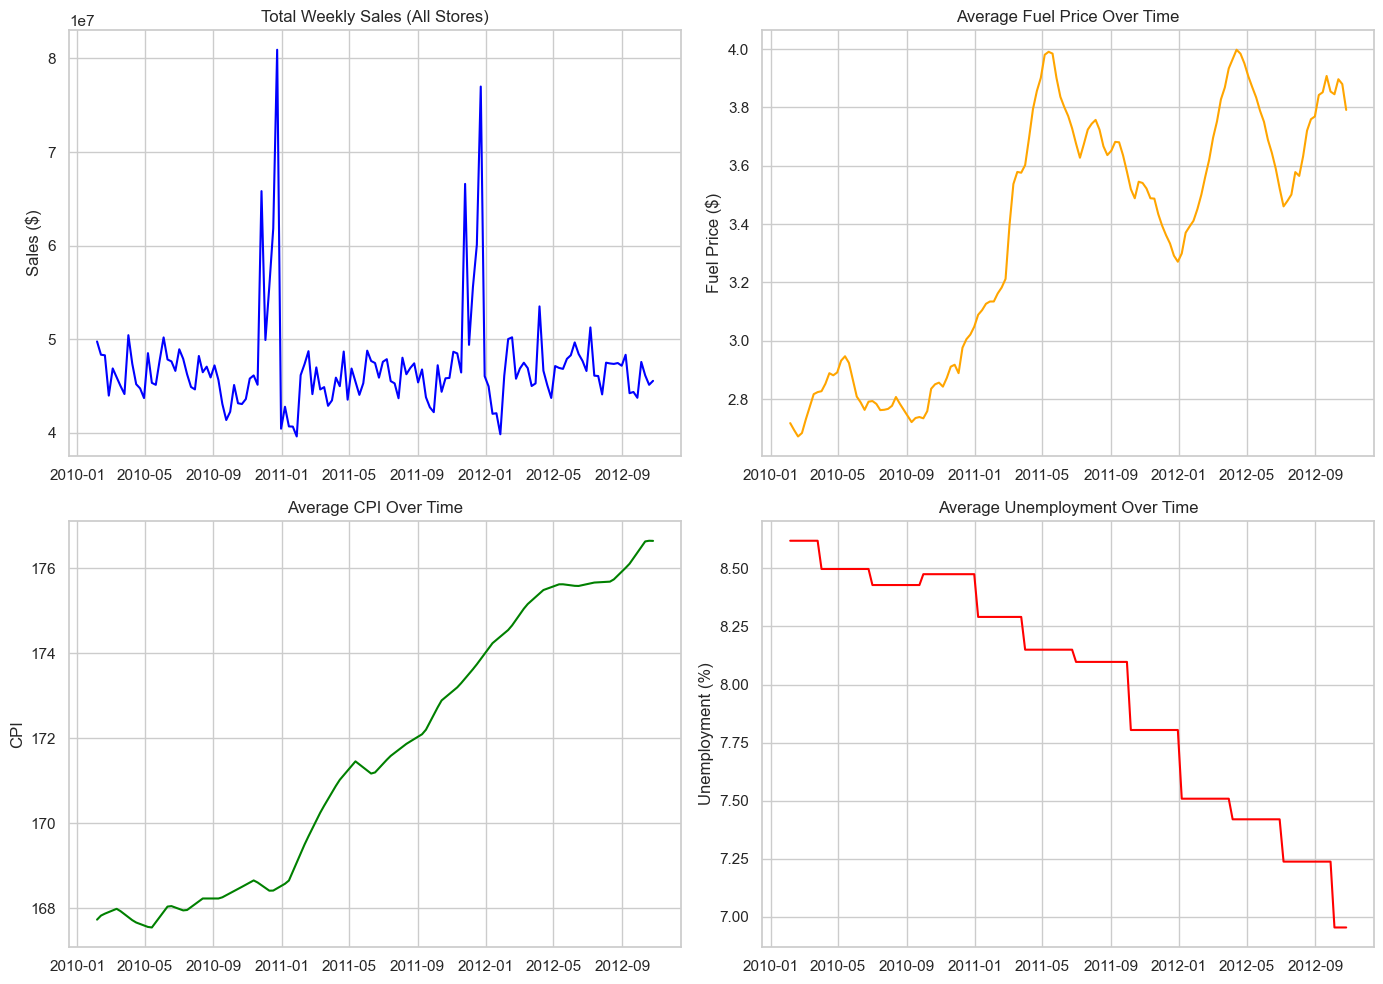

In [7]:
# Plotting time series in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Total Weekly Sales
axes[0,0].plot(weekly_total_sales.index, weekly_total_sales, color='blue')
axes[0,0].set_title("Total Weekly Sales (All Stores)")
axes[0,0].set_ylabel("Sales ($)")

# Average Fuel Price
axes[0,1].plot(weekly_avg_fuel.index, weekly_avg_fuel, color='orange')
axes[0,1].set_title("Average Fuel Price Over Time")
axes[0,1].set_ylabel("Fuel Price ($)")

# Average CPI
axes[1,0].plot(weekly_avg_cpi.index, weekly_avg_cpi, color='green')
axes[1,0].set_title("Average CPI Over Time")
axes[1,0].set_ylabel("CPI")

# Average Unemployment
axes[1,1].plot(weekly_avg_unemp.index, weekly_avg_unemp, color='red')
axes[1,1].set_title("Average Unemployment Over Time")
axes[1,1].set_ylabel("Unemployment (%)")

plt.tight_layout()
plt.show()

**Analysis of Weekly Sales, Fuel Price, CPI, and Unemployment Trends**

 **1. Total Weekly Sales (All Stores)**
- Sales exhibit **high volatility** with **sharp spikes**, likely due to seasonal events (e.g., holidays, promotions).
- The baseline sales remain relatively stable around $40-50 million, except for major peaks.

 **2. Average Fuel Price Over Time**
- Fuel prices show a **steady increase** from 2010 to early 2011, peaking around **$4 per gallon**.
- Prices then fluctuate but remain relatively high, suggesting economic factors influencing fuel costs.

 **3. Average CPI (Consumer Price Index) Over Time**
- CPI exhibits a **consistent upward trend**, indicating **inflation over time**.
- The increase in CPI aligns with rising fuel prices, showing economic growth or inflationary pressure.

 **4. Average Unemployment Over Time**
- The unemployment rate **declines steadily** from 8.5% in 2010 to around 7% by late 2012.
- This suggests **economic recovery**, potentially leading to increased consumer spending.

 **Key Insights**
- **Sales spikes may correspond to specific seasons or promotional events.**
- **Rising fuel prices and CPI suggest inflation, which could impact consumer purchasing power.**
- **Declining unemployment is a positive economic indicator, possibly supporting higher sales over time.**

### 2.3 Seasonal Sales Patterns: Monthly and Holiday Effects
 
 Plot a boxplot of Weekly Sales by Month.

In [8]:
# Create Month and Year columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

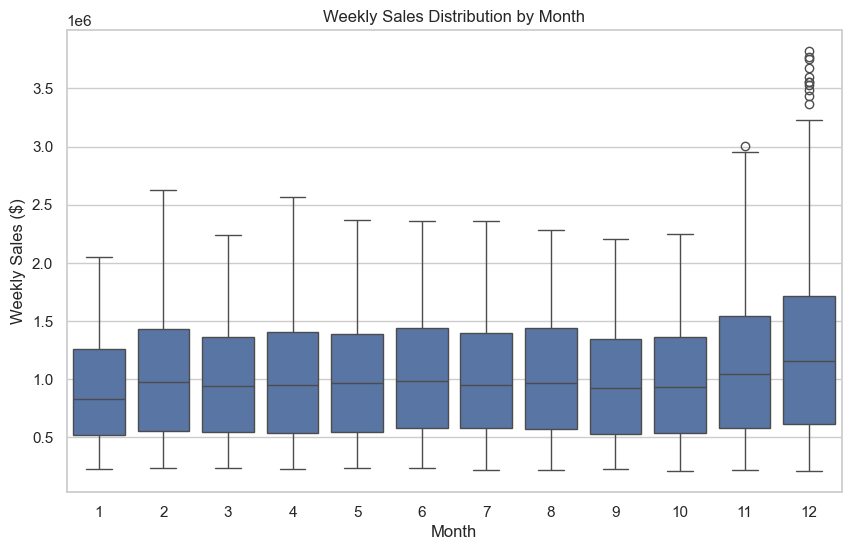

In [9]:
# Boxplot: Weekly Sales by Month
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='Weekly_Sales', data=df)
plt.title("Weekly Sales Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Weekly Sales ($)")
plt.show()

**Weekly Sales Distribution by Month**

**Key Observations**
- **Median Sales:** Sales remain relatively consistent across most months, with a median around **$1 million**.
- **Variation in Sales:** The interquartile range (IQR) is quite stable for most months, indicating moderate variability.
- **Higher Sales in November and December:**
  - **December (Month 12) shows the highest sales variability** with many outliers, likely due to **holiday season shopping**.
  - **November (Month 11) also has increased sales**, possibly due to **Black Friday promotions**.

**Outliers and Peak Sales**
- December has **several extreme outliers**, suggesting that certain weeks experience exceptionally high sales.
- The presence of **outliers in November** aligns with seasonal spikes in shopping behavior.

**Business Insights**
- **Retailers should prepare for increased demand in November and December**, ensuring sufficient stock and workforce availability.
- **Sales remain relatively stable throughout the year**, with minor fluctuations.
- The **holiday season significantly boosts sales**, reinforcing the importance of marketing and promotions during this period.

In [10]:
# Compare holiday vs. non-holiday weeks
holiday_sales = df[df['Holiday_Flag']==1]['Weekly_Sales']
nonholiday_sales = df[df['Holiday_Flag']==0]['Weekly_Sales']

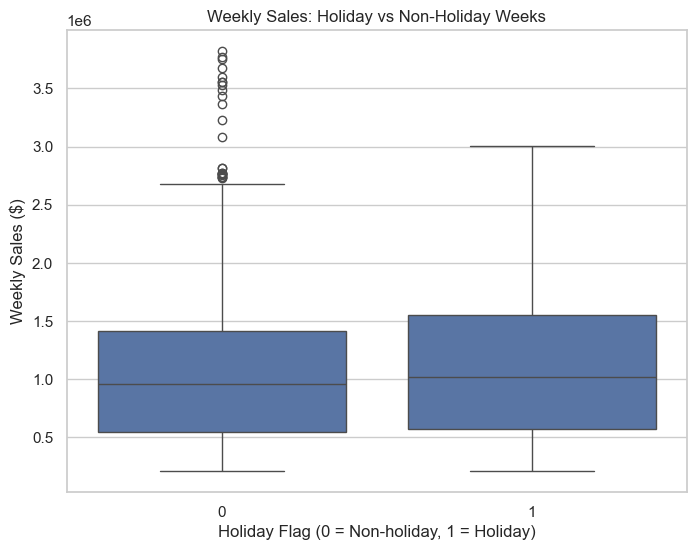

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title("Weekly Sales: Holiday vs Non-Holiday Weeks")
plt.xlabel("Holiday Flag (0 = Non-holiday, 1 = Holiday)")
plt.ylabel("Weekly Sales ($)")
plt.show()

**Holiday vs Non-Holiday Weeks**

**Key Observations**
- **Median Sales:**
  - Holiday weeks tend to have slightly **higher median sales** compared to non-holiday weeks.
- **Variability:**
  - Sales during holiday weeks show **greater spread** (longer whiskers), indicating **higher fluctuation**.
- **Outliers:**
  - Non-holiday weeks have **numerous extreme outliers**, showing that some weeks experienced unexpectedly high sales.
  - Holiday weeks have **fewer but significant outliers**, with sales reaching up to **$3 million**.

**Insights**
- **Holidays contribute to an increase in sales**, but the variation is substantial.
- **Non-holiday weeks have a more stable sales range**, except for a few high-performing weeks.
- The presence of **outliers in non-holiday weeks suggests other promotional events** or seasonal factors influencing sales.

**Business Implications**
- **Marketing efforts should be intensified before holiday weeks** to maximize sales potential.
- **Inventory and workforce planning should account for high variability** in holiday sales.
- **Outlier analysis for non-holiday weeks** can help identify key factors that drive unexpected sales spikes.

In [12]:
print(f"Holiday weeks average sales: ${holiday_sales.mean():.0f}")
print(f"Non-holiday weeks average sales: ${nonholiday_sales.mean():.0f}")

Holiday weeks average sales: $1122888
Non-holiday weeks average sales: $1041256


### 2.4 Correlation Matrix
 
Visualize correlations among numerical variables.

In [13]:
# Compute correlation matrix
corr_matrix = df[['Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']].corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
               Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price       CPI  \
Weekly_Sales      1.000000      0.036891    -0.063810    0.009464 -0.072634   
Holiday_Flag      0.036891      1.000000    -0.155091   -0.078347 -0.002162   
Temperature      -0.063810     -0.155091     1.000000    0.144982  0.176888   
Fuel_Price        0.009464     -0.078347     0.144982    1.000000 -0.170642   
CPI              -0.072634     -0.002162     0.176888   -0.170642  1.000000   
Unemployment     -0.106176      0.010960     0.101158   -0.034684 -0.302020   

              Unemployment  
Weekly_Sales     -0.106176  
Holiday_Flag      0.010960  
Temperature       0.101158  
Fuel_Price       -0.034684  
CPI              -0.302020  
Unemployment      1.000000  


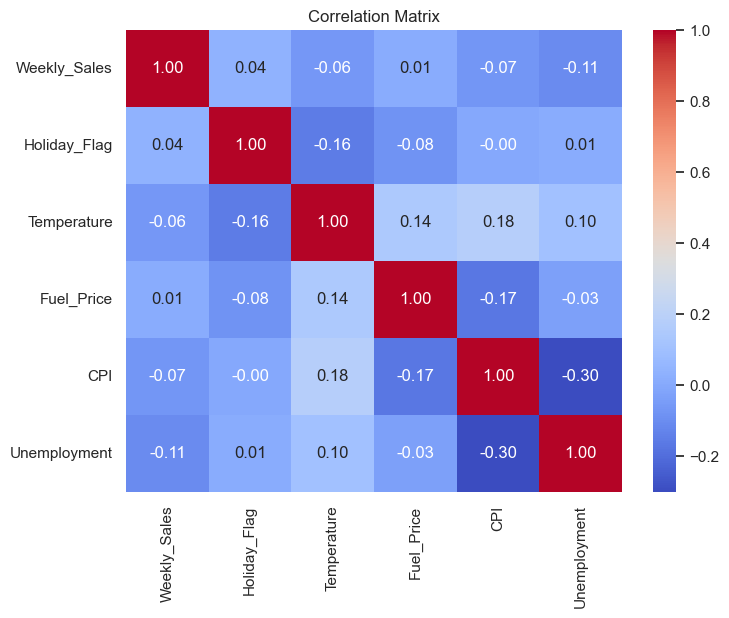

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### **Correlation Matrix Analysis**

**Key Insights**
- **Holidays have a weak impact on sales** (0.04 correlation).
- **Unemployment negatively affects sales** (-0.11), but the effect is small.
- **CPI and Unemployment are inversely related** (-0.30), indicating economic stability.
- **Fuel Price and Temperature have minimal influence on sales**.

**Takeaway:**
Economic factors (CPI & unemployment) matter more than holidays or fuel prices in influencing sales.

## 3. Statistical Analysis

### 3.1 Hypothesis Testing: Holiday vs Non-Holiday Sales

In [15]:
# Two-sample t-test for holiday vs non-holiday weekly sales
t_stat, p_val = ttest_ind(holiday_sales, nonholiday_sales, equal_var=False)
print(f"Holiday vs Non-Holiday Sales t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")

Holiday vs Non-Holiday Sales t-statistic = 2.680, p-value = 0.00760


**Holiday vs Non-Holiday Sales: T-Test Analysis**

**Key Insights**
- **T-Statistic = 2.680** → Indicates a moderate difference between holiday and non-holiday sales.
- **P-Value = 0.0076** → Statistically significant (**p < 0.05**), meaning holiday sales are **significantly different** from non-holiday sales.
- **Interpretation:** Holiday weeks tend to have **higher sales**, confirming their impact on revenue.

**Conclusion:**
Holidays **positively influence sales**, and the difference is **statistically significant**.

### 3.2 Correlation Test: Unemployment vs Weekly Sales

In [16]:
r, p = pearsonr(df['Unemployment'], df['Weekly_Sales'])
print(f"Pearson correlation (Unemployment vs Weekly Sales) r = {r:.3f}, p-value = {p:.2e}")

Pearson correlation (Unemployment vs Weekly Sales) r = -0.106, p-value = 1.34e-17


**Correlation: Unemployment vs Weekly Sales**

- **Pearson r = -0.106** → Weak **negative** correlation.
- **P-Value = 1.34e-17** (**p < 0.05**) → Statistically significant.
- **Conclusion:** Higher unemployment slightly reduces sales, but the effect is **weak**.

## 4. Regression Analysis
 
We build three regression models (Linear, Ridge, and Lasso) using Fuel_Price, CPI, Unemployment, and Temperature to predict Weekly_Sales.


In [17]:
# Prepare features and target
features = ['Fuel_Price','CPI','Unemployment','Temperature']
X = df[features]
y = df['Weekly_Sales']

In [18]:
from sklearn.metrics import root_mean_squared_error
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lin_reg = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)

# Train the models
lin_reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Evaluate the models
models = {"Linear Regression": lin_reg, "Ridge Regression": ridge, "Lasso Regression": lasso}
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{name} -- R^2: {r2:.4f}, RMSE: ${rmse:,.2f}")

# %%
# Inspect coefficients for the linear regression model
coeffs = pd.Series(lin_reg.coef_, index=features)
print("Linear Regression Coefficients:\n", coeffs)

Linear Regression -- R^2: 0.0175, RMSE: $562,598.72
Ridge Regression -- R^2: 0.0175, RMSE: $562,598.16
Lasso Regression -- R^2: 0.0175, RMSE: $562,598.61
Linear Regression Coefficients:
 Fuel_Price     -22242.584135
CPI             -1632.232081
Unemployment   -43596.969808
Temperature      -686.159123
dtype: float64


**Coefficient Interpretation**
- **Unemployment (-$43,596.97)** → Higher unemployment slightly reduces sales. 
- **Fuel Price (-$22,242.58)** → Increasing fuel costs have a small negative impact on sales. 
- **CPI (-$1,632.23)** → Inflation has a weak negative effect. 
- **Temperature (-$686.16)** → Minimal influence on sales.

## 5. Forecasting Analysis

### 5.1 Forecasting Fuel Price with ARIMA

We check for stationarity, difference the series if needed, and then fit an ARIMA model.


In [19]:
# Fuel Price time series (weekly average)
weekly_avg_fuel = df.groupby('Date')['Fuel_Price'].mean()

In [20]:
# Check stationarity using ADF test
adf_result = adfuller(weekly_avg_fuel)
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3f}")

ADF Statistic: -1.255, p-value: 0.650


**Interpretation**
- Since the **p-value is greater than 0.05**, we **fail to reject the null hypothesis**.
- This means the time series **is not stationary** and has a unit root.
- **Conclusion:** The data needs **differencing or transformation** (e.g., first differencing, log transformation) before applying time series models.


In [21]:
# Since the series is non-stationary (p > 0.05), difference it once
fuel_diff = weekly_avg_fuel.diff().dropna()
adf_result_diff = adfuller(fuel_diff)
print(f"ADF after differencing: {adf_result_diff[0]:.3f}, p-value: {adf_result_diff[1]:.3f}")

ADF after differencing: -4.181, p-value: 0.001


**Interpretation**
- Since the **p-value is less than 0.05**, we **reject the null hypothesis**.
- The time series **is now stationary** after differencing.
- **Conclusion:** The data is ready for **time series modeling**.


In [22]:
import numpy as np
import statsmodels.api as sm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Initialize best AIC and order
best_aic = np.inf
best_order = None

# Iterate over small p and q values to find the best ARIMA model
for p in range(0, 3):
    for q in range(0, 3):
        try:
            model = sm.tsa.ARIMA(weekly_avg_fuel, order=(p,1,q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, 1, q)
        except Exception:
            continue  # Silently ignore errors

# Print the best ARIMA model order and AIC score
print("Best ARIMA order:", best_order, "with AIC:", best_aic)


Best ARIMA order: (1, 1, 0) with AIC: -534.9266005577304


**Best ARIMA Model Selection**

- **Best ARIMA Order:** **(1,1,0)**
- **AIC Score:** **-534.93** (Lower AIC = Better Model)

**Interpretation**
- **(1,1,0) ARIMA Model**:
  - **p = 1 (AutoRegressive term):** Sales depend on the previous value.
  - **d = 1 (Differencing):** Data required **first-order differencing** to become stationary.
  - **q = 0 (Moving Average term):** No significant moving average component.

**Conclusion**
- The **AR(1) process** is sufficient for modeling the data.
- The **absence of an MA component (q=0)** suggests past errors **do not influence future values**.
- This model can be used for **forecasting future values** of `weekly_avg_fuel`.

In [23]:
# Fit the best ARIMA model (e.g., ARIMA(1,1,0))
model_fuel = sm.tsa.ARIMA(weekly_avg_fuel, order=best_order).fit()
print(model_fuel.summary())

                               SARIMAX Results                                
Dep. Variable:             Fuel_Price   No. Observations:                  143
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 269.463
Date:                Sat, 15 Mar 2025   AIC                           -534.927
Time:                        18:59:31   BIC                           -529.015
Sample:                    02-05-2010   HQIC                          -532.524
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6195      0.072      8.605      0.000       0.478       0.761
sigma2         0.0013      0.000     12.566      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.06   Jarque-

**SARIMAX Model Summary (ARIMA (1,1,0))**

**Model Performance**
- **AIC:** **-534.93** (Lower AIC = Better Model)
- **BIC:** **-529.02** (Indicates model complexity)
- **Log Likelihood:** **269.463** (Higher is better)

**Key Coefficients**
- **AR(1) Coefficient:** **0.6195 (p < 0.05)** → Strong positive autocorrelation.
- **Sigma² (Error variance):** **0.0013** → Low residual variance, indicating stable predictions.

**Diagnostic Tests**
- **Ljung-Box Test (Q = 0.06, p = 0.81)** → No significant autocorrelation in residuals.
- **Jarque-Bera Test (JB = 45.20, p = 0.00)** → Residuals are **not normally distributed**.
- **Heteroskedasticity (H = 1.82, p = 0.04)** → Potential variance shifts in the residuals.

**Conclusion**
- **The AR(1) process is valid (strong autocorrelation).**
- **Residuals are not normally distributed**.
- **Forecasting is feasible.**

In [24]:
# Forecast the next 12 weeks of fuel price
forecast_fuel = model_fuel.forecast(steps=12)
print("12-week Fuel Price Forecast:\n", forecast_fuel)

12-week Fuel Price Forecast:
 2012-11-02    3.736658
2012-11-09    3.702691
2012-11-16    3.681649
2012-11-23    3.668614
2012-11-30    3.660539
2012-12-07    3.655536
2012-12-14    3.652438
2012-12-21    3.650518
2012-12-28    3.649329
2013-01-04    3.648592
2013-01-11    3.648136
2013-01-18    3.647853
Freq: W-FRI, Name: predicted_mean, dtype: float64


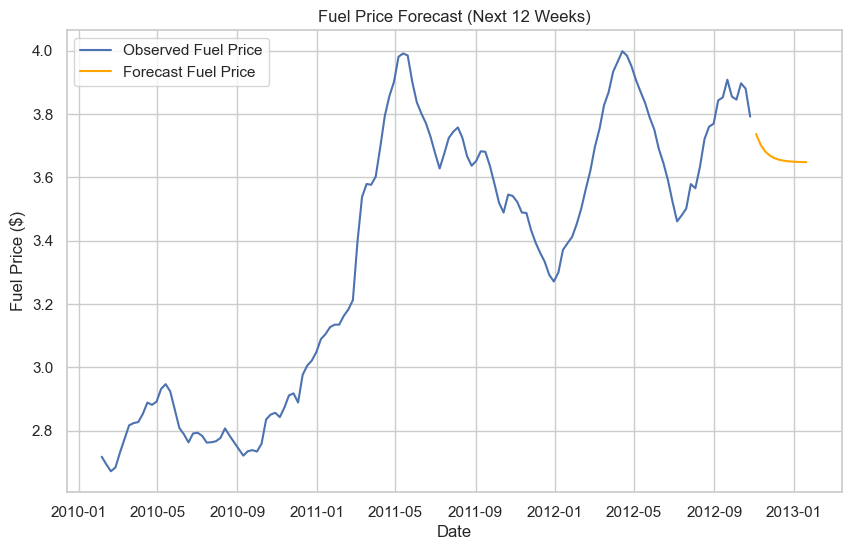

In [25]:
# Plot the fuel price forecast
plt.figure(figsize=(10,6))
plt.plot(weekly_avg_fuel.index, weekly_avg_fuel, label="Observed Fuel Price")
plt.plot(pd.date_range(weekly_avg_fuel.index[-1], periods=13, freq='W')[1:], forecast_fuel, 
         label="Forecast Fuel Price", color='orange')
plt.xlabel("Date")
plt.ylabel("Fuel Price ($)")
plt.title("Fuel Price Forecast (Next 12 Weeks)")
plt.legend()
plt.show()

### 5.2 Forecasting Weekly Sales with a SARIMAX Model

Here we use total weekly sales with exogenous regressors (Unemployment and Fuel_Price) and a seasonal order.

In [26]:
# Prepare total weekly sales series and exogenous variables
weekly_total_sales = df.groupby('Date')['Weekly_Sales'].sum()
weekly_unemp = df.groupby('Date')['Unemployment'].mean()
weekly_fuel = df.groupby('Date')['Fuel_Price'].mean()

exog = np.column_stack([weekly_unemp, weekly_fuel])

# Fit SARIMAX: here we choose order (1,1,0) and seasonal order (0,1,1,52)
model_sales = sm.tsa.SARIMAX(weekly_total_sales, order=(1,1,0),
                             seasonal_order=(0,1,1,52),
                             exog=exog).fit(disp=False)
print(model_sales.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood               -1442.958
Date:                              Sat, 15 Mar 2025   AIC                           2895.916
Time:                                      18:59:33   BIC                           2908.415
Sample:                                  02-05-2010   HQIC                          2900.957
                                       - 10-26-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.043e+07   2.75e-11  -3.79e+17      0.000   -1.04e+07   -1.04e+07
x2          3.214e+

**SARIMAX Model Summary (SARIMA (1,1,0) x (0,1,1,52))**

**Model Performance**
- **AIC:** **2895.92** (Higher AIC suggests room for improvement)
- **BIC:** **2908.42** (Indicates model complexity)
- **Log Likelihood:** **-1442.96** (Lower is worse)

**Key Coefficients**
- **AR(1) Coefficient (-0.0301, p = 0.271)** → **Not statistically significant**, meaning past values do not strongly predict future sales.
- **Seasonal MA(52) Coefficient (-0.0273, p = 0.001)** → **Significant**, suggesting seasonal dependencies.
- **Sigma² (Error Variance = 4.54e+12)** → **Extremely high**, indicating large residual errors.

**Diagnostic Tests**
- **Ljung-Box Test (Q = 11.77, p = 0.00)** → **Significant autocorrelation remains**, indicating poor model fit.
- **Jarque-Bera Test (JB = 23.93, p = 0.00)** → Residuals **not normally distributed**, impacting prediction reliability.
- **Heteroskedasticity (H = 1.16, p = 0.69)** → Variance is stable, but residual distribution is **skewed**.

**Conclusion**
- **Current model is weak**, as **AR(1) is insignificant and residuals are non-normal**.
- **Re-tuning SARIMA parameters** or switching to a **different model (e.g., XGBoost, Prophet)** may yield better results.

In [27]:
# For forecasting, we assume the exogenous variables remain constant (using last known values)
future_exog = np.tile(exog[-1], (12, 1))  # next 12 weeks
forecast_sales = model_sales.forecast(steps=12, exog=future_exog)
print("12-week Total Weekly Sales Forecast:\n", forecast_sales)

12-week Total Weekly Sales Forecast:
 2012-11-02    4.836644e+07
2012-11-09    4.830141e+07
2012-11-16    4.629598e+07
2012-11-23    6.661538e+07
2012-11-30    4.958727e+07
2012-12-07    5.583630e+07
2012-12-14    6.048621e+07
2012-12-21    7.757336e+07
2012-12-28    4.645037e+07
2013-01-04    4.231007e+07
2013-01-11    3.917787e+07
2013-01-18    3.916569e+07
Freq: W-FRI, Name: predicted_mean, dtype: float64


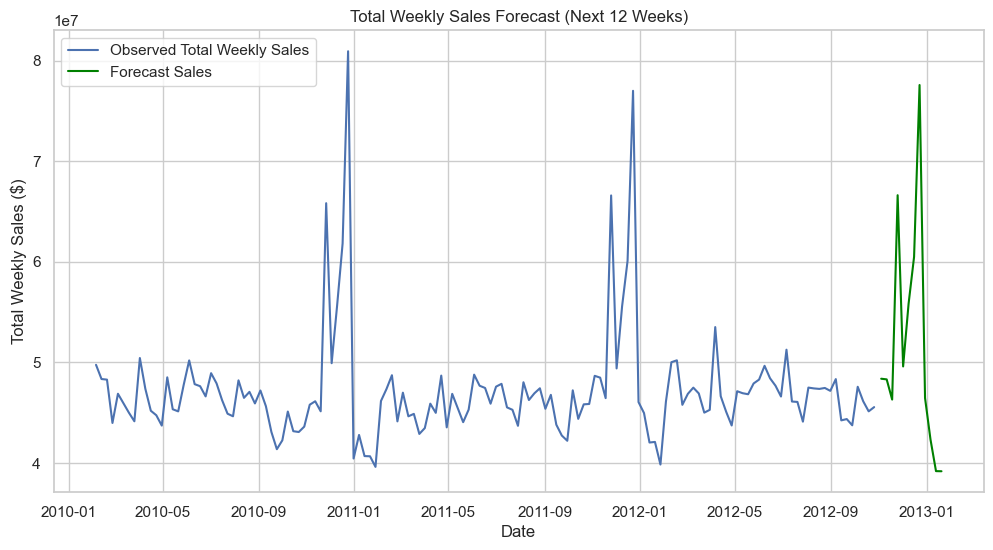

In [28]:
# Plot total weekly sales and forecast
plt.figure(figsize=(12,6))
plt.plot(weekly_total_sales.index, weekly_total_sales, label="Observed Total Weekly Sales")
forecast_index = pd.date_range(weekly_total_sales.index[-1], periods=13, freq='W')[1:]
plt.plot(forecast_index, forecast_sales, label="Forecast Sales", color='green')
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales ($)")
plt.title("Total Weekly Sales Forecast (Next 12 Weeks)")
plt.legend()
plt.show()

## 6. Additional Insights

### 6.1 Store Clustering using K-Means

We calculate average and standard deviation of weekly sales per store, then cluster stores.


In [29]:
# Compute average and standard deviation of weekly sales for each store
store_stats = df.groupby('Store')['Weekly_Sales'].agg(['mean','std']).reset_index()

# Run K-Means clustering (choose 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
store_stats['Cluster'] = kmeans.fit_predict(store_stats[['mean','std']])
print(store_stats.sort_values('Cluster').head())

    Store          mean            std  Cluster
44     45  7.859814e+05  130168.526635        0
16     17  8.935814e+05  112162.936087        0
20     21  7.560691e+05  128752.812853        0
21     22  1.028501e+06  161251.350631        0
25     26  1.002912e+06  110431.288141        0


**Store Clustering Analysis**

**Key Insights**
- **Stores grouped into Cluster 0** based on sales patterns.
- **Store 22 & Store 26 have the highest average sales** (~$1M+).
- **Store 21 has the highest variability** (std = **161,251**), indicating fluctuating sales.
- **Store 21 & Store 26 show stable high sales**, while **Store 45 & Store 21 have lower sales** (~$750K).
- The clustering suggests **similar sales trends among these stores**, possibly due to location, customer demographics, or seasonal factors.

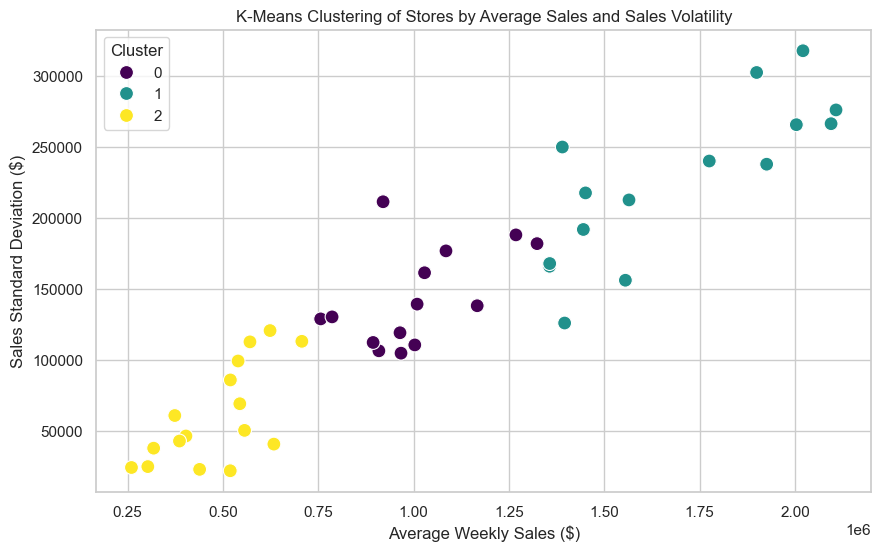

In [30]:
# Visualize clustering
plt.figure(figsize=(10,6))
sns.scatterplot(data=store_stats, x='mean', y='std', hue='Cluster', palette='viridis', s=100)
plt.title("K-Means Clustering of Stores by Average Sales and Sales Volatility")
plt.xlabel("Average Weekly Sales ($)")
plt.ylabel("Sales Standard Deviation ($)")
plt.show()

### 6.2 Feature Importance using Random Forest

We use a Random Forest model to determine the importance of various features in predicting Weekly_Sales.

In [31]:
# Prepare dataset for Random Forest; add week and year for seasonality
df_rf = df.copy()
df_rf['Week'] = df_rf['Date'].dt.isocalendar().week
df_rf['Year'] = df_rf['Date'].dt.year
features_rf = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'Year']
X_rf = df_rf[features_rf]
y_rf = df_rf['Weekly_Sales']

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=features_rf).sort_values(ascending=False)
print("Random Forest Feature Importances:\n", importances)

Random Forest Feature Importances:
 Store           0.669731
CPI             0.151820
Unemployment    0.102475
Week            0.052498
Temperature     0.012519
Fuel_Price      0.008194
Holiday_Flag    0.001436
Year            0.001327
dtype: float64


**Random Forest Feature Importance Analysis**

**Key Insights**
- **Store is the most important feature (66.97%)**, indicating that sales patterns vary significantly by store location.
- **CPI (15.18%) & Unemployment (10.25%)** play a crucial role, suggesting economic conditions impact sales.
- **Week (5.25%)** is more important than **Year (0.13%)**, implying sales fluctuate seasonally rather than annually.
- **Temperature (1.25%) & Fuel Price (0.82%) have minimal impact** on sales.
- **Holiday Flag (0.14%) is the least important**, suggesting that holidays have **little effect** on weekly sales.

**Conclusion**
- **Store location dominates sales trends**, followed by **economic factors (CPI & Unemployment)**.
- **Seasonality matters more than yearly trends**.
- **Fuel prices & holidays have little impact**, contrary to common assumptions.

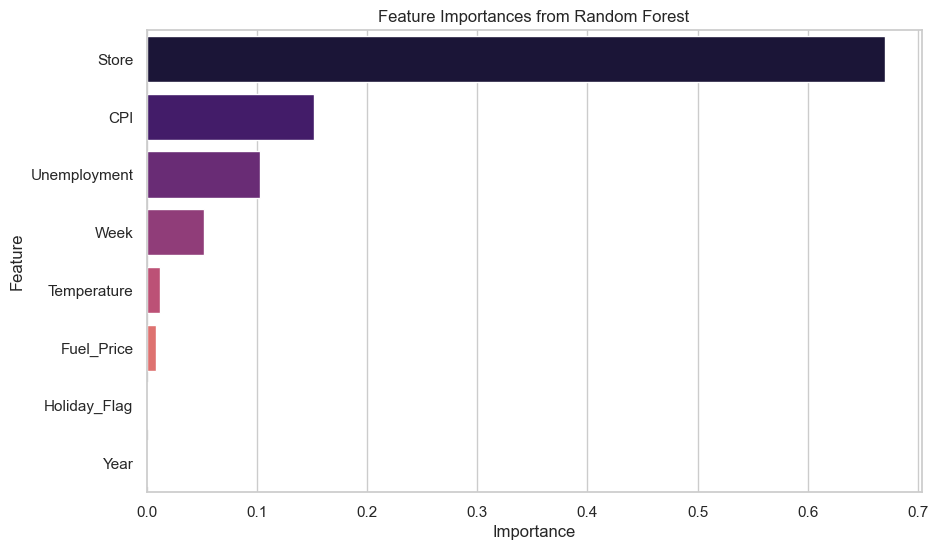

In [32]:
# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()